<img src="https://panel.holoviz.org/_static/logo_stacked.png" width=150 align="left" margin=20px>

The [Panel](http://panel.holoviz.org) library from [HoloViz](http://holoviz.org) lets you make widget-controlled apps and dashboards from a wide variety of [plotting libraries and data types](https://panel.holoviz.org/reference/index.html#panes).  

**Here we set up four different plotting libraries controlled by a couple of widgets, for Hans Rosling's [gapminder](https://demo.bokeh.org/gapminder) example.**

In [ ]:
import param
import numpy as np 
import pandas as pd
import panel as pn

import altair as alt
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
import hvplot.pandas

pn.extension('vega', 'plotly', defer_load=True, sizing_mode="stretch_width")

We need to define some configuration

In [ ]:
XLABEL = 'GDP per capita (2000 dollars)'
YLABEL = 'Life expectancy (years)'
YLIM = (20, 90)
HEIGHT=500 # pixels
WIDTH=500 # pixels
ACCENT="#00A170"

PERIOD = 1000 # miliseconds

## Extract the dataset

First, we'll get the data into a Pandas dataframe. We use the [built in `cache`](https://panel.holoviz.org/user_guide/Performance_and_Debugging.html#caching) to speed up the app.

In [ ]:
@pn.cache
def get_dataset():
    url = 'https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv'
    return pd.read_csv(url)

In [ ]:
dataset = get_dataset()
dataset.sample(10)

In [ ]:
YEARS = [int(year) for year in dataset.year.unique()]
YEARS

## Transform the dataset to plots

Now let's define helper functions and functions to plot this dataset with Matplotlib, Plotly, Altair, and hvPlot (using HoloViews and Bokeh).

In [ ]:
@pn.cache
def get_data(year):
    df = dataset[(dataset.year==year) & (dataset.gdpPercap < 10000)].copy()
    df['size'] = np.sqrt(df['pop']*2.666051223553066e-05)
    df['size_hvplot'] = df['size']*6
    return df

def get_title(library, year):
    return f"{library}: Life expectancy vs. GDP, {year}"

def get_xlim(data):
    return (data['gdpPercap'].min()-100,data['gdpPercap'].max()+1000)

Let's define the **Matplotlib** plotting function.

In [ ]:
plt.rcParams.update({
    "savefig.facecolor": (0.0, 0.0, 0.0, 0.0), 
})


@pn.cache
def mpl_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("Matplotlib", year)
    xlim = get_xlim(data)

    plot = plt.figure(figsize=(10, 6))
    ax = plot.add_subplot(111)
    ax.set_xscale("log")
    ax.set_title(title)
    ax.set_xlabel(XLABEL)
    ax.set_ylabel(YLABEL)
    ax.set_ylim(YLIM)
    ax.set_xlim(xlim)

    for continent, df in data.groupby('continent'):
        ax.scatter(df.gdpPercap, y=df.lifeExp, s=df['size']*5,
                   edgecolor='black', label=continent)

    if show_legend:
        ax.legend(loc=4)

    plt.close(plot)
    return plot

mpl_view(1952, True)

Let's define the **Plotly** plotting function.

In [ ]:
pio.templates.default = None

@pn.cache
def plotly_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("Plotly", year)
    xlim = get_xlim(data)

    traces = []
    for continent, df in data.groupby('continent'):
        marker=dict(symbol='circle', sizemode='area', sizeref=0.1, size=df['size'], line=dict(width=2))
        traces.append(go.Scatter(x=df.gdpPercap, y=df.lifeExp, mode='markers', marker=marker, name=continent, text=df.country))

    axis_opts = dict(gridcolor='rgb(255, 255, 255)', zerolinewidth=1, ticklen=5, gridwidth=2)
    layout = go.Layout(title=title, showlegend=show_legend,
        xaxis=dict(title=XLABEL, type='log', **axis_opts),
        yaxis=dict( title=YLABEL, **axis_opts), autosize=True,
        paper_bgcolor='rgba(0,0,0,0)',
        )
    
    return go.Figure(data=traces, layout=layout)

plotly_view()

Let's define the **Altair** plotting function.

In [ ]:
@pn.cache
def altair_view(year=1952, show_legend=True, height="container", width="container"):
    data = get_data(year)
    title = get_title("Altair/ Vega", year)
    xlim = get_xlim(data)
    legend= ({} if show_legend else {'legend': None})

    plot  = alt.Chart(data, ).mark_circle().encode(
        alt.X('gdpPercap:Q', scale=alt.Scale(type='log'), axis=alt.Axis(title=XLABEL)),
        alt.Y('lifeExp:Q', scale=alt.Scale(zero=False, domain=YLIM), axis=alt.Axis(title=YLABEL)),
        size=alt.Size('pop:Q', scale=alt.Scale(type="log"), legend=None),
        color=alt.Color('continent', scale=alt.Scale(scheme="category10"), **legend),
        tooltip=['continent','country'])\
        .configure_axis(grid=False) \
        .properties(title=title, height=height, width=width, background='rgba(0,0,0,0)') \
        .configure_view(fill="white")
    return plot.interactive()

altair_view(height=HEIGHT-100, width=1000)

Let's define the **hvPlot** plotting function. Please note that [hvPlot](https://hvplot.holoviz.org/) is the recommended entry point to the HoloViz plotting ecosystem.

In [ ]:
@pn.cache
def hvplot_view(year=1952, show_legend=True):
    data = get_data(year)
    title = get_title("hvPlot/ Bokeh", year)
    xlim = get_xlim(data)

    plot  = data.hvplot.scatter('gdpPercap', 'lifeExp', by='continent', s='size_hvplot', alpha=0.6,
              logx=True, title=title, height=HEIGHT, responsive=True, legend=show_legend, hover_cols=['country'])
    plot  = plot.opts(legend_position='bottom_right', xticks=[500, 1000, 2000, 5000, 10000])
    plot  = plot.redim.label(gdpPercap=XLABEL, lifeExp=YLABEL)
    plot  = plot.redim.range(lifeExp=YLIM, gdpPercap=(200, 12000))
    return plot

hvplot_view()

## Define the widgets

In [ ]:
year = pn.widgets.DiscreteSlider(value=YEARS[-1], options=YEARS, name="Year")
show_legend = pn.widgets.Checkbox(value=True, name="Show Legend")

In [ ]:
def play():
    print("play")
    if year.value == YEARS[-1]:
        year.value=YEARS[0]
        return
    
    index = YEARS.index(year.value)
    year.value = YEARS[index+1]    

periodic_callback = pn.state.add_periodic_callback(play, start=False, period=PERIOD)
player = pn.widgets.Checkbox.from_param(periodic_callback.param.running, name="Autoplay")

In [ ]:
widgets = pn.Column(year, player, show_legend, margin=(0,15))
widgets

## Bind the plot functions to the widgets

In [ ]:
mpl_view = pn.bind(mpl_view, year=year, show_legend=show_legend)
plotly_view = pn.bind(plotly_view, year=year, show_legend=show_legend)
altair_view = pn.bind(altair_view, year=year, show_legend=show_legend, height=HEIGHT-100)
hvplot_view = pn.bind(hvplot_view, year=year, show_legend=show_legend)

## Layout the widgets

In [ ]:
logo  = pn.pane.PNG("https://panel.holoviz.org/_static/logo_stacked.png", link_url="https://panel.holoviz.org", embed=False, width=150, align="center")
    
desc = """## 🎓 Info

The [Panel](http://panel.holoviz.org) library from [HoloViz](http://holoviz.org)
lets you make widget-controlled apps and dashboards from a wide variety of 
plotting libraries and data types. Here you can try out four different plotting libraries
controlled by a couple of widgets, for Hans Rosling's 
[gapminder](https://demo.bokeh.org/gapminder) example.

Source: [pyviz-topics - gapminder](https://github.com/pyviz-topics/examples/blob/master/gapminders/gapminders.ipynb)
"""

settings = pn.Column(
        logo, "## ⚙️ Settings", widgets, desc
)
settings

## Layout the plots

We layout the plots in a [Gridbox](https://panel.holoviz.org/reference/layouts/GridBox.html) with 2 columns. Please note Panel provides many other [layouts](https://panel.holoviz.org/reference/index.html#layouts) that might be perfect for your use case.

In [ ]:
plots = pn.layout.GridBox(
    pn.Row(pn.Spacer(), pn.panel(mpl_view, height=HEIGHT, sizing_mode="scale_height"), pn.Spacer()),
    hvplot_view,
    pn.panel(plotly_view, config={'responsive': True}, margin=(5,5,0,0)),
    pn.panel(altair_view, height=500),
    ncols=2, sizing_mode="stretch_both",
)

Note how we mark the components `.servable()`. This will allow us to serve this notebook as a data app via `panel serve gapminder.ipynb`.

## Configure the template

Let us layout out the app in the nicely styled [FastListTemplate](https://panel.holoviz.org/reference/templates/FastListTemplate.html).

In [ ]:
pn.template.FastListTemplate(
    sidebar=[settings],
    main=[plots],
    site="Panel",
    site_url="https://panel.holoviz.org",
    title="Hans Rosling's Gapminder",
    header_background=ACCENT,
    accent_base_color=ACCENT,
    favicon="static/extensions/panel/images/favicon.ico",
    theme_toggle=False,
).servable(); # We add the ; to avoid showing the app in the notebook

The final data app can be served via `panel serve gapminder.ipynb`.

It will look something like.

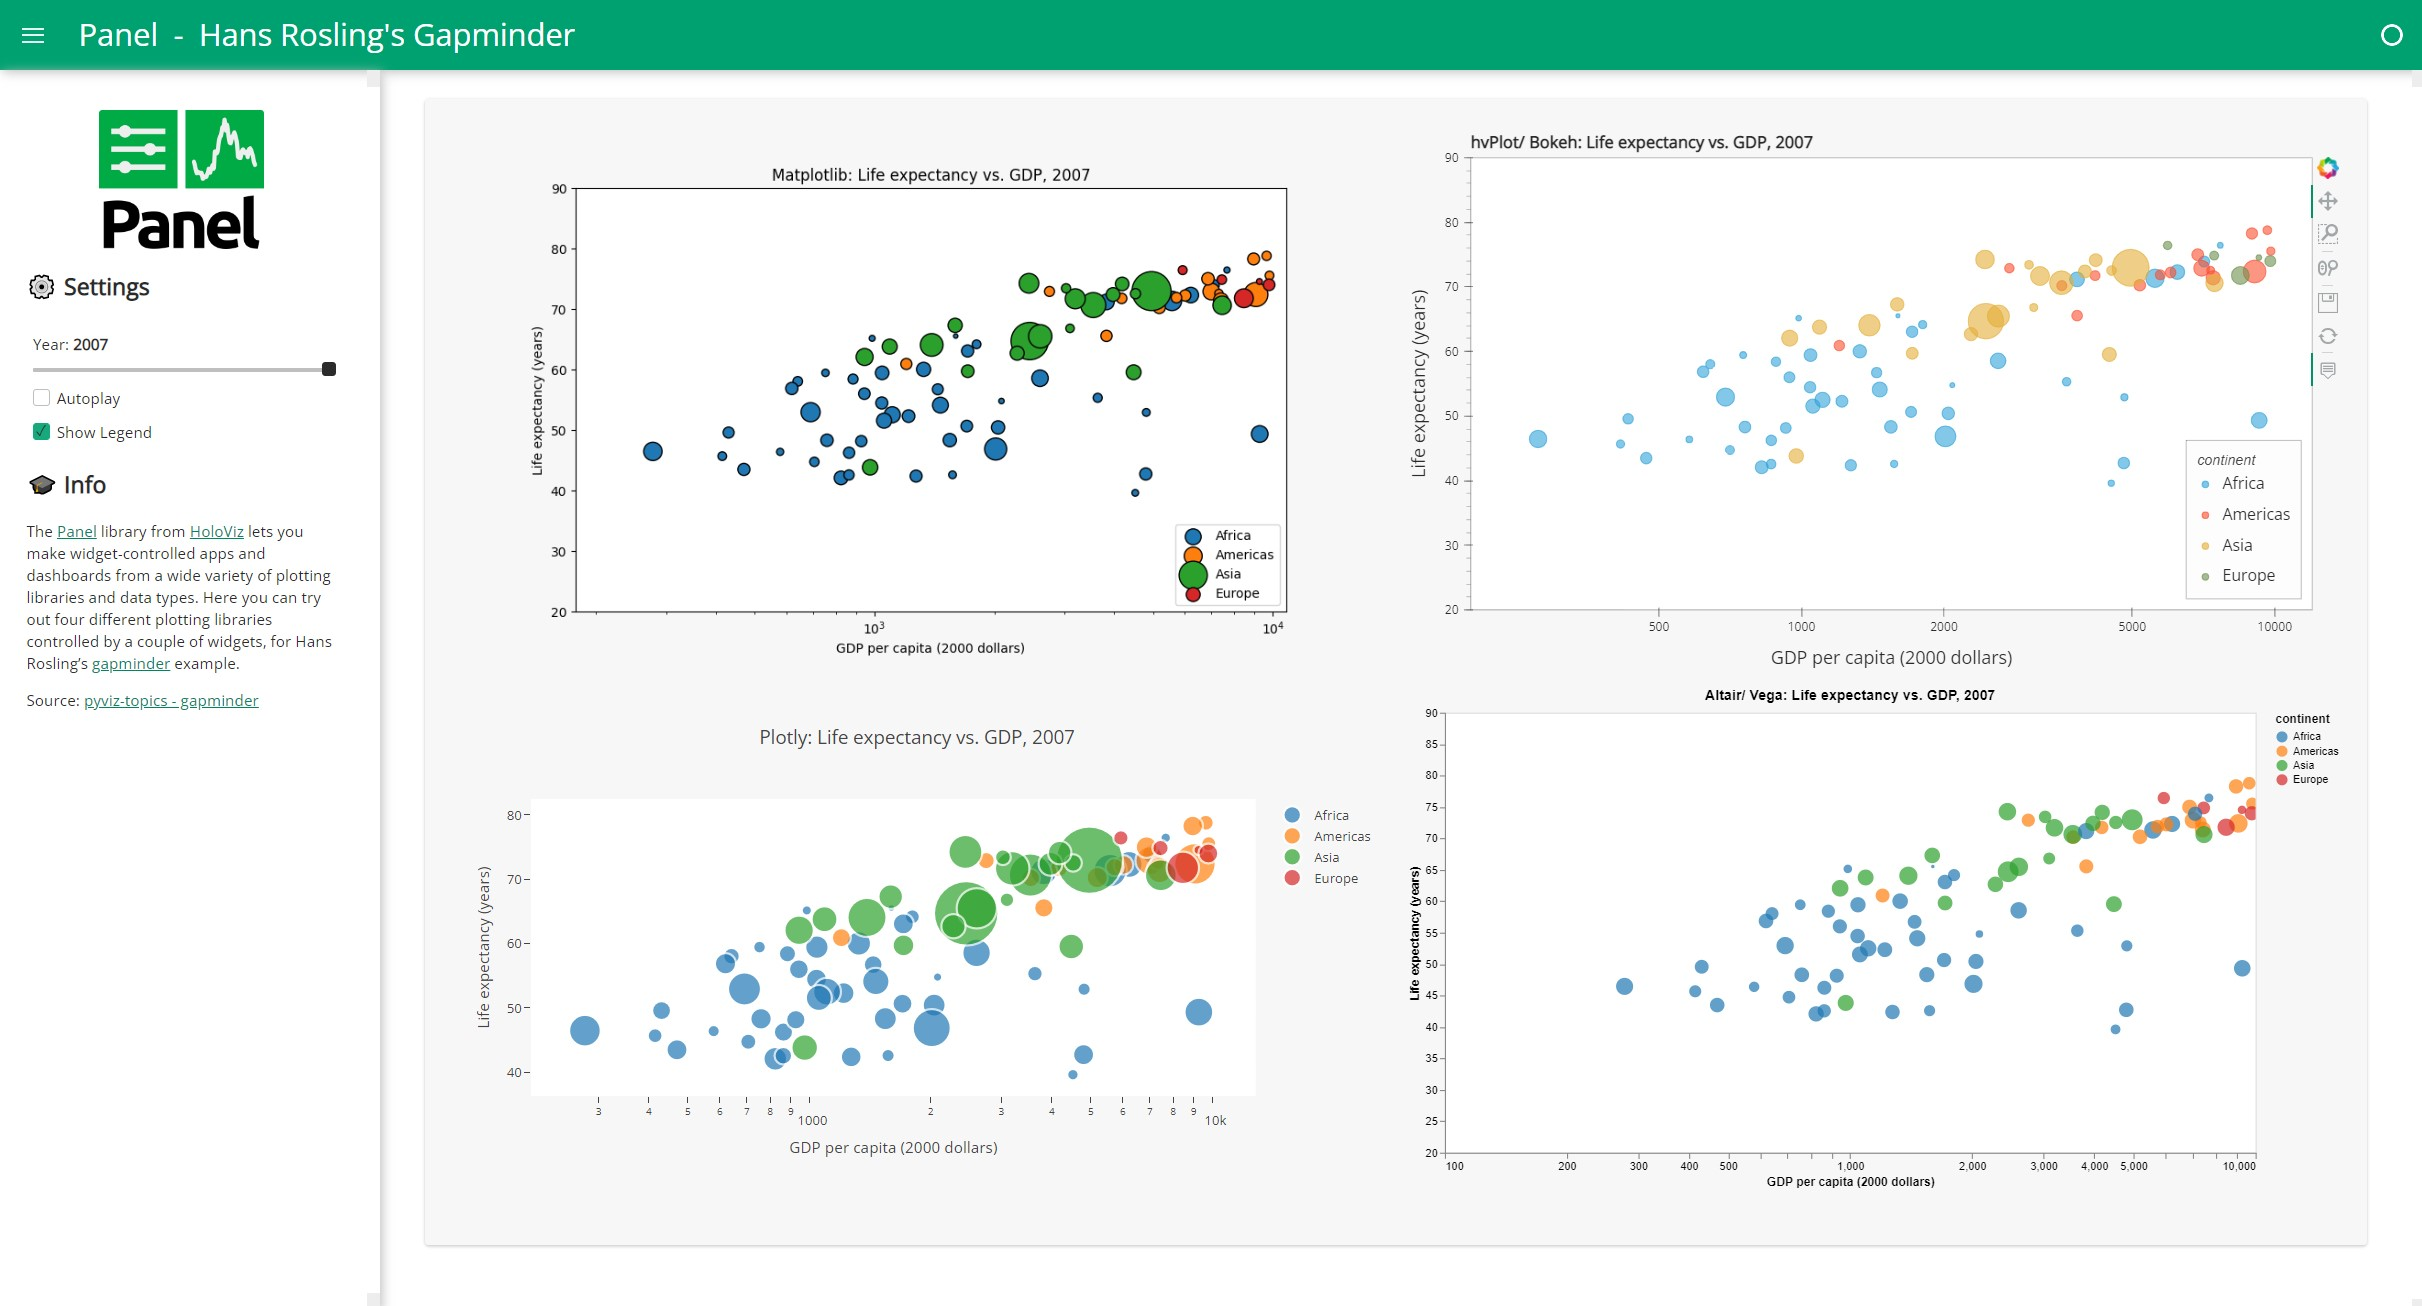